In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import matplotlib
import ipyparams

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import func_optimize as fo
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
import neurolib.dashboard.layout as layout
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

cmap_ = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors_rgba()
exc_red = cmap_(3)
inh_blue=cmap_(0)
green = cmap_(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [53]:
savepath = (os.getcwd().split('neurolib')[0] + 'Talks_Conf_Workshops_Schools' + os.sep + '22' + os.sep + 'FRANCE22' + 
     os.sep + 'FENS' + os.sep + 'poster' + os.sep + 'print' + os.sep + 'images')

exc = 0.4
inh = 0.322

In [167]:
dur_pre = 10
dur_post = 10
dur = 500.
dt = aln.params.dt
T = int(1 + dur / dt)

max_it = 10
init_it = 10
prec_vars = [0,1]
trans_time = 0.7
repeat = 20

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

maxC = [5., -5., 0.18, 0.]
n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

nb = ipyparams.notebook_name
print('nb = ', nb)

case = str(nb[4])

if case in ['1', '2']:
    max_I = [3., -3.]
elif case in ['3', '4']:
    max_I = [3., -3.]

read_file = '..' + os.sep + 'data_2' + os.sep + 'high_osc' + os.sep  + '1_I.pickle'

nb =  osc_high.ipynb


In [125]:
if os.path.isfile(read_file) :
    print("file found")
    
    with open(read_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl = load_array
    
init_control_noisefree = bestControl[0].copy()

file found


In [251]:
sigma_ou_array = [0.01, 0.02]
noise_realizations_array = [0,20,100]
noise_realizations_final = 10000

In [252]:
n_sig = len(sigma_ou_array)
n_noise = len(noise_realizations_array)

i_sigma = 0
i_noise = 1
i = 50

int_t_pen = np.around( (1. - trans_time)*dur/aln.params.dt, 1).astype(int)

cost_final_mean = np.zeros(( n_sig,n_noise ))
target = [None] * n_sig
control_ = [ [None] * n_noise, [None] * n_noise ]
cost_ = control_.copy()
cost_final = control_.copy()

stable_state = np.zeros(( n_noise, 2,2,2, 2))

In [253]:
# get init vars without noise
aln = ALNModel()
data.set_parameters(aln)
aln.params.duration = 3000.

# initial without noise
control0 = aln.getZeroControl()
control0[0,0,:500] = -5.

aln.params.ext_exc_current = exc * 5.
aln.params.ext_inh_current = inh * 5.

aln.run(control=control0)

init_state_vars = np.zeros(( len(state_vars) ))
for j in range(len(state_vars)):
    if aln.state[state_vars[j]].size == 1:
        init_state_vars[j] = aln.state[state_vars[j]][0]
    else:
        init_state_vars[j] = aln.state[state_vars[j]][0,-1]

initVars = init_state_vars

# final state without noise
control0 = aln.getZeroControl()
control0[0,0,:500] = 5.
if case in ['3', '4']:
    control0[0,0,:500] = - 5.

aln.params.duration = 3000.
aln.run(control=control0)
stable_state[0,0,1,0,0] = aln.rates_exc[0,-1]
stable_state[0,0,1,1,0] = aln.rates_inh[0,-1]

print('exc high ', stable_state[0,0,1,0,0])
print('inh high ', stable_state[0,0,1,1,0])

exc high  25.73160170281955
inh high  65.38404842698914


In [254]:
for i_sigma in range(len(sigma_ou_array)):
    
    sigma_ou = sigma_ou_array[i_sigma]
    aln.params.sigma_ou = sigma_ou
    
    aln.params.duration = dur
    control0 = aln.getZeroControl()
    control0[0,0,:500] = 5.

    target_rates_e = []
    target_rates_i = []

    stateswitchcount = 0

    for j in range(noise_realizations_final):
        aln.params.duration = dur
        setinit(initVars, aln)
        aln.run(control=control0)
        #plt.plot(aln.t, aln.rates_exc[0,:])
        if np.amin(aln.rates_exc[0,1000:]) < 1.:
            #print("fell in down state, repeat")
            j -= 1
            stateswitchcount += 1
            if stateswitchcount > 0.1 * noise_realizations_final:
                break
            continue
        target_rates_e = aln.rates_exc[0,-int_t_pen:]
        target_rates_i = aln.rates_inh[0,-int_t_pen:]
    
    #print(stateswitchcount)
    #plt.show()
    
    aln.params.duration = dur
    target[i_sigma] = aln.getZeroTarget()
    target[i_sigma][:,0,:] = np.mean(target_rates_e)
    target[i_sigma][:,1,:] = np.mean(target_rates_i)

    stable_state[i_sigma,1,1,0,0] = np.mean(target_rates_e)
    stable_state[i_sigma,1,1,1,0] = np.mean(target_rates_i)
    stable_state[i_sigma,1,1,0,1] = np.std(target_rates_e)
    stable_state[i_sigma,1,1,1,1] = np.std(target_rates_i)


    aln.params.duration = 300.
    control0 = aln.getZeroControl()
    control0[0,0,:500] = -5.

    target_rates_e = []
    target_rates_i = []

    stateswitchcount = 0

    for j in range(noise_realizations_final):
        aln.params.duration = 300.
        aln.run(control=control0)
        #plt.plot(aln.t, aln.rates_exc[0,:])
        if np.amax(aln.rates_exc[0,1000:]) > 20.:
            #print("fell in up state, repeat")
            j -= 1
            stateswitchcount += 1
            if stateswitchcount > 0.1 * noise_realizations_final:
                break
            continue
        target_rates_e.append(aln.rates_exc[0,1000:])
        target_rates_i.append(aln.rates_inh[0,1000:])
        
    #print(stateswitchcount)
    #plt.show()

    stable_state[i_sigma,1,0,0,0] = np.mean(target_rates_e)
    stable_state[i_sigma,1,0,1,0] = np.mean(target_rates_i)
    stable_state[i_sigma,1,0,0,1] = np.std(target_rates_e)
    stable_state[i_sigma,1,0,1,1] = np.std(target_rates_i)
    
    print(i_sigma, 'st dev osc ', stable_state[i_sigma,1,0,0,1] )

0 st dev osc  0.8764466281985089
1 st dev osc  1.1477415904750843


In [294]:
aln.params.sigma_ou = sigma_ou

w_p = 1. / ( ( stable_state[i_sigma,1,1,0,1] + stable_state[i_sigma,1,1,1,1] ) * (1. - trans_time) * dur )
w_e = 0.
w_s = 1.

aln.params.duration = dur
zero_init = aln.getZeroControl()

In [297]:
max_it = 15
init_it = 5
min_it = 12
i = 50
    
cost.setParams(w_p, w_e, w_s)

for i_sigma in range(len(sigma_ou_array)):
    for i_noise in range(len(noise_realizations_array)):
        
        if i_noise in [0,2]:
            continue
            
        if i_sigma in [1]:
            continue

        noise_realizations = noise_realizations_array[i_noise]
        sigma_ou = sigma_ou_array[i_sigma]
        aln.params.sigma_ou = sigma_ou
        
        aln.params.duration = dur
        
        n_ = 0
        control_sum = np.zeros(( init_control_noisefree[:,:,:].shape ))
        
        print(noise_realizations)
        
        if i_noise in [1,2]:
                
            print('--------', n_)

            setinit(initVars, aln)
            
            #zero_init[0,1,1500:2000] = -3.

            bestControl, bestState, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                zero_init, target[i_sigma], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                control_variables_ = [1], prec_variables_ = prec_vars, transition_time_ = trans_time,
                noise_real=noise_realizations, init_params = initVars, method='M3')

            control_init = bestControl[:,:,100:-100].copy()
            setinit(initVars, aln)
            aln.params.duration = dur

            bestControl, bestState, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                control_init, target[i_sigma], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
                tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
                noise_real=noise_realizations, init_params = initVars, method='M3')
            
            control_[i_sigma][i_noise] = bestControl
        
        else:
            control_[i_sigma][i_noise] = factor[i_sigma] * init_control_noisefree
        
        aln.params.duration = dur
        setinit(initVars, aln)

        init_control = aln.getZeroControl()           
        init_control[:,:,:] = control_[i_sigma][i_noise][:,:,100:-100]
        T = int(1 + dur/aln.params.dt)
        dt = aln.params.dt

        target_ = target[i_sigma].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000

        cost_final = 0.
        cs = cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

        for n_ in range(noise_realizations_final):
            state_ = fo.updateState(aln, init_control)
            cost_final += cost.numba_cost_precision_int(1,T,dt,w_p[i_sigma],state_, target_, list(prec_vars) )

        cost_final_mean[i_sigma, i_noise] = cs + cost_final / noise_realizations_final
        print('mean = ', cost_final_mean[i_sigma, i_noise])

set cost params:  0.002319594243401671 0.0 1.0
20
-------- 0
start
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  578.1835307860564
Gradient descend method:  None
RUN  1 , total integrated cost =  46.12673610838623
RUN  2 , total integrated cost =  42.433909518577494
RUN  3 , total integrated cost =  4.4168448231575015
RUN  4 , total integrated cost =  31.706789359754453
RUN  5 , total integrated cost =  55.10423728292604
RUN  5 , total integrated cost mean =  55.10423728292604
Improved over  5  iterations in  14.326681362988893  seconds by  90.46942115282836  percent.
start
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  157.36746010326073
Gradient descend method:  None
RUN  1 , total integrated cost =  109.59037802107385
RUN  2 , total integrated cost =  117.60246364127178
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  1.956467037381092
RUN  4 , total

In [190]:
i_sigma = 0
i_noise = 0
sigma_ou = sigma_ou_array[i_sigma]
aln.params.sigma_ou = sigma_ou

for factor in np.arange(2.0, 2.0, 0.1):

    init_control = aln.getZeroControl()           
    init_control[:,:,:] = factor * init_control_noisefree[:,:,100:-100]
    T = int(1 + dur/aln.params.dt)
    dt = aln.params.dt

    target_ = target[i_sigma].copy()
    target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
    target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000

    cost_final = np.zeros(( noise_realizations_final ))

    for n_ in range(noise_realizations_final):
        state_ = fo.updateState(aln, init_control)
        cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p,state_, target_, list(prec_vars) )
        cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

    print('factor, mean = ', factor, np.mean(cost_final))
    
factor = [2.1, 3.]
control_[i_sigma][i_noise] = factor[i_sigma] * init_control_noisefree

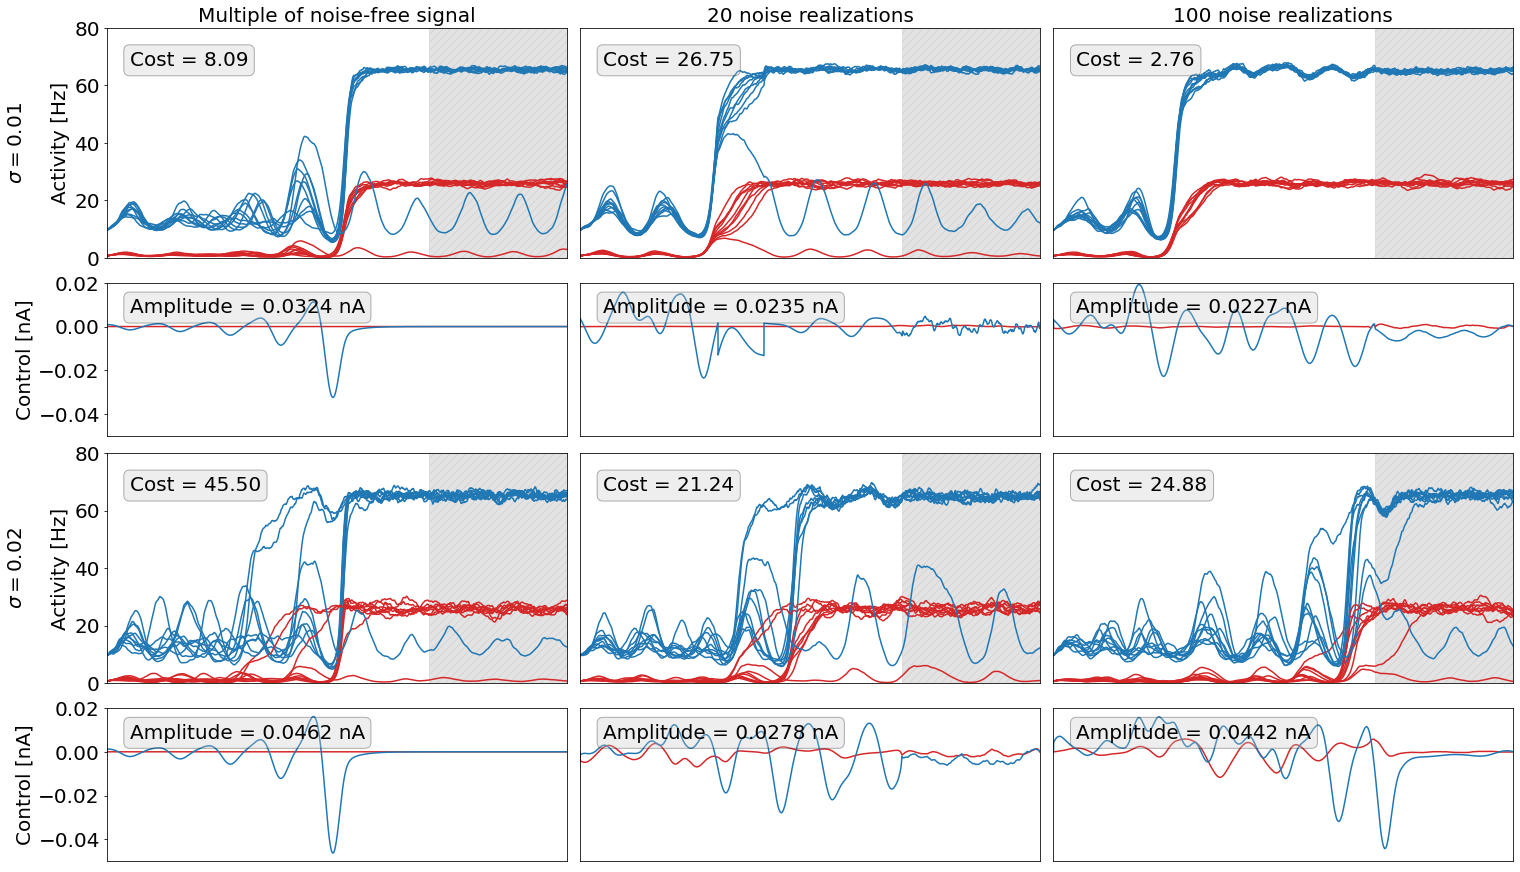

In [296]:
fs_ = 20
fig, ax = plt.subplots(4, 3, figsize=(21,12), constrained_layout=True, facecolor='white',
                       gridspec_kw={'height_ratios': [3,2,3,2]})
#fig.suptitle('Point b', fontsize=fs_)
plot_realizations = 10
i = 50

t_array = np.arange(0,dur+aln.params.dt,aln.params.dt)
ax[0,0].set_title('Multiple of noise-free signal', fontsize=fs_)

setinit(initVars, aln)
aln.params.duration = dur

for i_sigma in range(len(sigma_ou_array)):
    for i_noise in range(len(noise_realizations_array)):
        
        if i_noise in []:
            continue
            
        if i_sigma in []:
            continue
        
        noise_realizations = noise_realizations_array[i_noise]
        sigma_ou = sigma_ou_array[i_sigma]
        aln.params.sigma_ou = sigma_ou
        
        if i_noise != 0:
            ax[0,i_noise].set_title('{} noise realizations'.format(noise_realizations), fontsize=fs_)

        ax[2*i_sigma+1,i_noise].plot( t_array, control_[i_sigma][i_noise][0,0,100:-100]/5., color=exc_red)
        ax[2*i_sigma+1,i_noise].plot( t_array, control_[i_sigma][i_noise][0,1,100:-100]/5., color=inh_blue)

        fail=0
        for indexx in range(plot_realizations):
                aln.run(control=control_[i_sigma][i_noise][:,:,100:-100])
                                
                if np.mean(aln.rates_inh[0,-100:]) < 50.:
                    fail += 1
                    
                if (indexx == plot_realizations - 1 and fail == 0 and [i_sigma, i_noise] != [0,2]):
                    while fail == 0:
                        aln.run(control=control_[i_sigma][i_noise][:,:,100:-100])
                        if np.mean(aln.rates_inh[0,-100:]) < 50.:
                            fail += 1
                    ax[2*i_sigma,i_noise].plot( t_array, aln.rates_exc[0,:], color=exc_red)
                    ax[2*i_sigma,i_noise].plot( t_array, aln.rates_inh[0,:], color=inh_blue)
                    
                else:
                    ax[2*i_sigma,i_noise].plot( t_array, aln.rates_exc[0,:], color=exc_red)
                    ax[2*i_sigma,i_noise].plot( t_array, aln.rates_inh[0,:], color=inh_blue)
                
                
            

        ax[2*i_sigma,i_noise].text(0.05, 0.9, 'Cost = {:.2f}'.format(cost_final_mean[i_sigma, i_noise]),
                horizontalalignment='left', verticalalignment='top', transform=ax[2*i_sigma,i_noise].transAxes,
                bbox=dict(boxstyle='round', facecolor=midgrey, alpha=0.3), fontsize=fs_)
        
        ax[2*i_sigma+1,i_noise].text(0.05, 0.9, 'Amplitude = {:.4f} nA'.format(
            np.amax(np.abs(control_[i_sigma][i_noise][0,:,100:-100]/5.))), horizontalalignment='left',
            verticalalignment='top', transform=ax[2*i_sigma+1,i_noise].transAxes,
            bbox=dict(boxstyle='round', facecolor=midgrey, alpha=0.3), fontsize=fs_)
        
    #ax[2*i_sigma+1,0].text(0.05, 0.9, 'Factor = {:.2f}'.format(factor[i_sigma]),
    #        horizontalalignment='left', verticalalignment='top', transform=ax[2*i_sigma+1,0].transAxes,
    #        bbox=dict(boxstyle='round', facecolor=midgrey, alpha=0.3), fontsize=fs_)

for j in range(4):
    for k in range(3):
        ax[j,k].tick_params(axis='x', labelsize=fs_)
        ax[j,k].tick_params(axis='y', labelsize=fs_)
        ax[j,k].set_xlim(0,dur)
        ax[j,k].grid(False)
        if j != 5:
            ax[j,k].set_xticks([])
        else:
            ax[j,k].set_xlabel('Time [ms]', fontsize=fs_)
        if k != 0:
            ax[j,k].set_yticks([])
        if j%2 == 0:
            ax[j,k].set_ylim(0,80)
            ax[j,0].set_yticks(np.arange(0,90,20))
            sigma_ou = sigma_ou_array[int(j/2)]
            ax[j,0].set_ylabel(r'$\sigma=$' + '{}'.format(sigma_ou) + '\n' + '\n' 
                                + 'Activity [Hz]', fontsize=fs_)
            ax[j,k].axvspan( dur*trans_time, dur, facecolor=midgrey,
                            alpha=0.5, zorder=-1, hatch='///', edgecolor = midgrey)
        elif j%2 == 1:
            ax[j,k].set_ylim(-0.05,0.02)
            ax[j,0].set_yticks(np.arange(-0.04,0.021,0.02))
            ax[j,0].set_ylabel('Control [nA]', fontsize=fs_)


filename_ = nb[:-6] + '.png'
    
fig.savefig(filename_)
fig.savefig(os.path.join(savepath, filename_))
plt.show()

In [202]:
aln.params.duration = dur
setinit(initVars, aln)

for i_sigma in range(len(sigma_ou_array)):
    for i_noise in range(len(noise_realizations_array)):
        
        if i_noise in [0,2,3]:
            continue
            
        if i_sigma in []:
            continue
            
        noise_realizations = noise_realizations_array[i_noise]
        sigma_ou = sigma_ou_array[i_sigma]
        aln.params.sigma_ou = sigma_ou

        init_control = aln.getZeroControl()           
        init_control[:,:,:] = control_[i_sigma][i_noise][:,:,100:-100]
        T = int(1 + dur/aln.params.dt)
        dt = aln.params.dt

        target_ = target[i_sigma].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000

        cost_final = np.zeros(( noise_realizations_final ))

        for n_ in range(noise_realizations_final):
            state_ = fo.updateState(aln, init_control)
            cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p,state_, target_, list(prec_vars) )
            #print('prec = ', cost_final[n_])
            cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)
            #print('spa ', cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control))
            
            #plt.plot(aln.t, aln.rates_exc[0,:])
        #plt.show()

        cost_final_mean[i_sigma, i_noise] = np.mean(cost_final)
        print('mean = ', cost_final_mean[i_sigma, i_noise])

mean =  2456.120627429252
mean =  2233.7747280357307
